9/9 [==============================] - 0s 661us/step
Iteration 1 - RMSE: 74701898.64370121, MAE: 62678876.599595964
9/9 [==============================] - 0s 677us/step
Iteration 2 - RMSE: 71834867.63366142, MAE: 61695413.52727274
9/9 [==============================] - 0s 628us/step
Iteration 3 - RMSE: 71509115.35712312, MAE: 62815342.442020215
9/9 [==============================] - 0s 675us/step
Iteration 4 - RMSE: 75017141.15273345, MAE: 63788211.20000001
9/9 [==============================] - 0s 796us/step
Iteration 5 - RMSE: 71439021.09668002, MAE: 60868812.80000001
9/9 [==============================] - 0s 630us/step
Iteration 6 - RMSE: 98091237.03759763, MAE: 82175294.68121213
9/9 [==============================] - 0s 649us/step
Iteration 7 - RMSE: 76005301.31096292, MAE: 65182521.01818182
9/9 [==============================] - 0s 629us/step
Iteration 8 - RMSE: 123139126.48882213, MAE: 106191767.71232323
9/9 [==============================] - 0s 664us/step
Iteration 9 - RMSE: 689

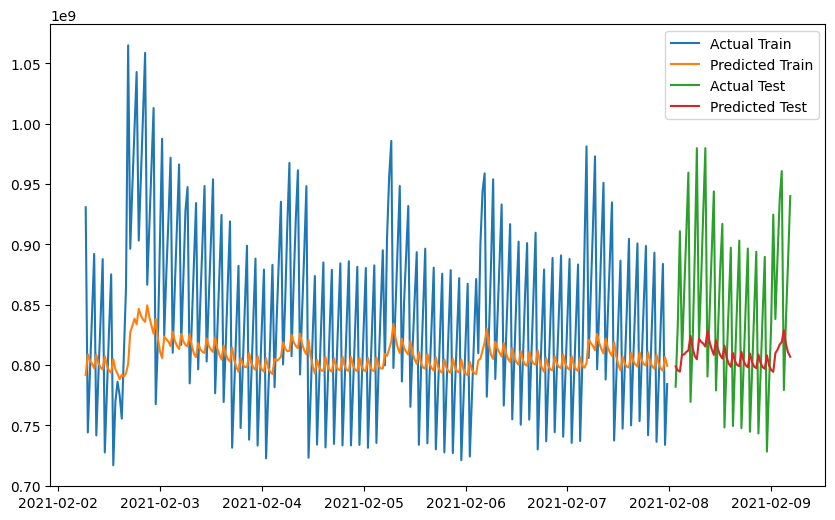

In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Load the time series data
metric_df = pd.read_pickle("../data/ts.pkl")

# Resample the data to 30-minute intervals
ts = metric_df["value"].astype(float).resample("30min").mean()

# Split the data into train and test sets
train = ts[:"2021-02-07"]
test = ts["2021-02-08":]

# Scale the data using a MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

# Define the number of time steps and features
n_steps = 3
n_features = 1

# Create sequences of input data and target values for train set
X_train, y_train = [], []
for i in range(n_steps, len(train_scaled)):
    X_train.append(train_scaled[i-n_steps:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data to be 3D
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))

# Number of times to train the model
num_iterations = 20

# List to store metrics
rmse_list = []
mae_list = []
test_preds = []
train_preds = []  # Step 1: Create a list to store the predicted train values for each iteration.

# Loop to train the model multiple times
for i in range(num_iterations):
    # Define the RNN model architecture
    model = Sequential()
    model.add(LSTM(10, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae')

    # Train the model
    model.fit(X_train, y_train, epochs=10, verbose=0)

    # Create sequences of input data and target values for test set
    X_test, y_test = [], []
    for j in range(n_steps, len(test_scaled)):
        X_test.append(test_scaled[j-n_steps:j, 0])
        y_test.append(test_scaled[j, 0])
    X_test, y_test = np.array(X_test), np.array(y_test)

    # Reshape the input data to be 3D
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], n_features))

    # Make predictions on the test set
    test_pred = model.predict(X_test)
    test_pred = scaler.inverse_transform(test_pred)
    test_preds.append(test_pred)

    # Make predictions on the train set  # Step 2: Make predictions on the train set.
    train_pred = model.predict(X_train)
    train_pred = scaler.inverse_transform(train_pred)
    train_preds.append(train_pred)  # Step 3: Append the predicted train values to the list created in step 1.

    # Evaluate the model on the test set and store metrics
    rmse = np.sqrt(np.mean((test_pred - test.values)**2))
    rmse_list.append(rmse)
    mae = mean_absolute_error(test.values[n_steps:], test_pred)
    mae_list.append(mae)

    # print metrics for each iteration if you want
    print(f"Iteration {i + 1} - RMSE: {rmse}, MAE: {mae}")

# Calculate the mean metrics
mean_rmse = np.mean(rmse_list)
mean_mae = np.mean(mae_list)

print("Mean RMSE:", mean_rmse)
print("Mean MAE:", mean_mae)

# Calculate the mean predicted train values  # Step 4: After the loop, calculate the mean predicted train values.
mean_train_preds = np.mean(train_preds, axis=0)

# Plot the actual vs predicted values for the train and test sets
plt.figure(figsize=(10, 6))
plt.plot(train.index[n_steps:], train.values[n_steps:], label="Actual Train")
plt.plot(train.index[n_steps:], mean_train_preds, label="Predicted Train")  # Step 5: Plot the mean predicted train values.
plt.plot(test.index[n_steps:], test.values[n_steps:], label="Actual Test")
plt.plot(test.index[n_steps:], np.mean(test_preds, axis=0), label="Predicted Test")
plt.legend()
plt.show()